Рассмотрим применение RNN для создания игровых уровней

по этому [адресу](https://nesmaps.com/maps/SuperMarioBrothers/SuperMarioBrothers.html) размещены карты уровней Супер Марио.

Возьмем от-туда [карту](https://nesmaps.com/maps/SuperMarioBrothers/SuperMarioBrosMap1-1.png)

<img src="https://nesmaps.com/maps/SuperMarioBrothers/SuperMarioBrosMap1-1.png">

Откроем ее в gimp. Включим сетку, и текстом прокодируем спрайты

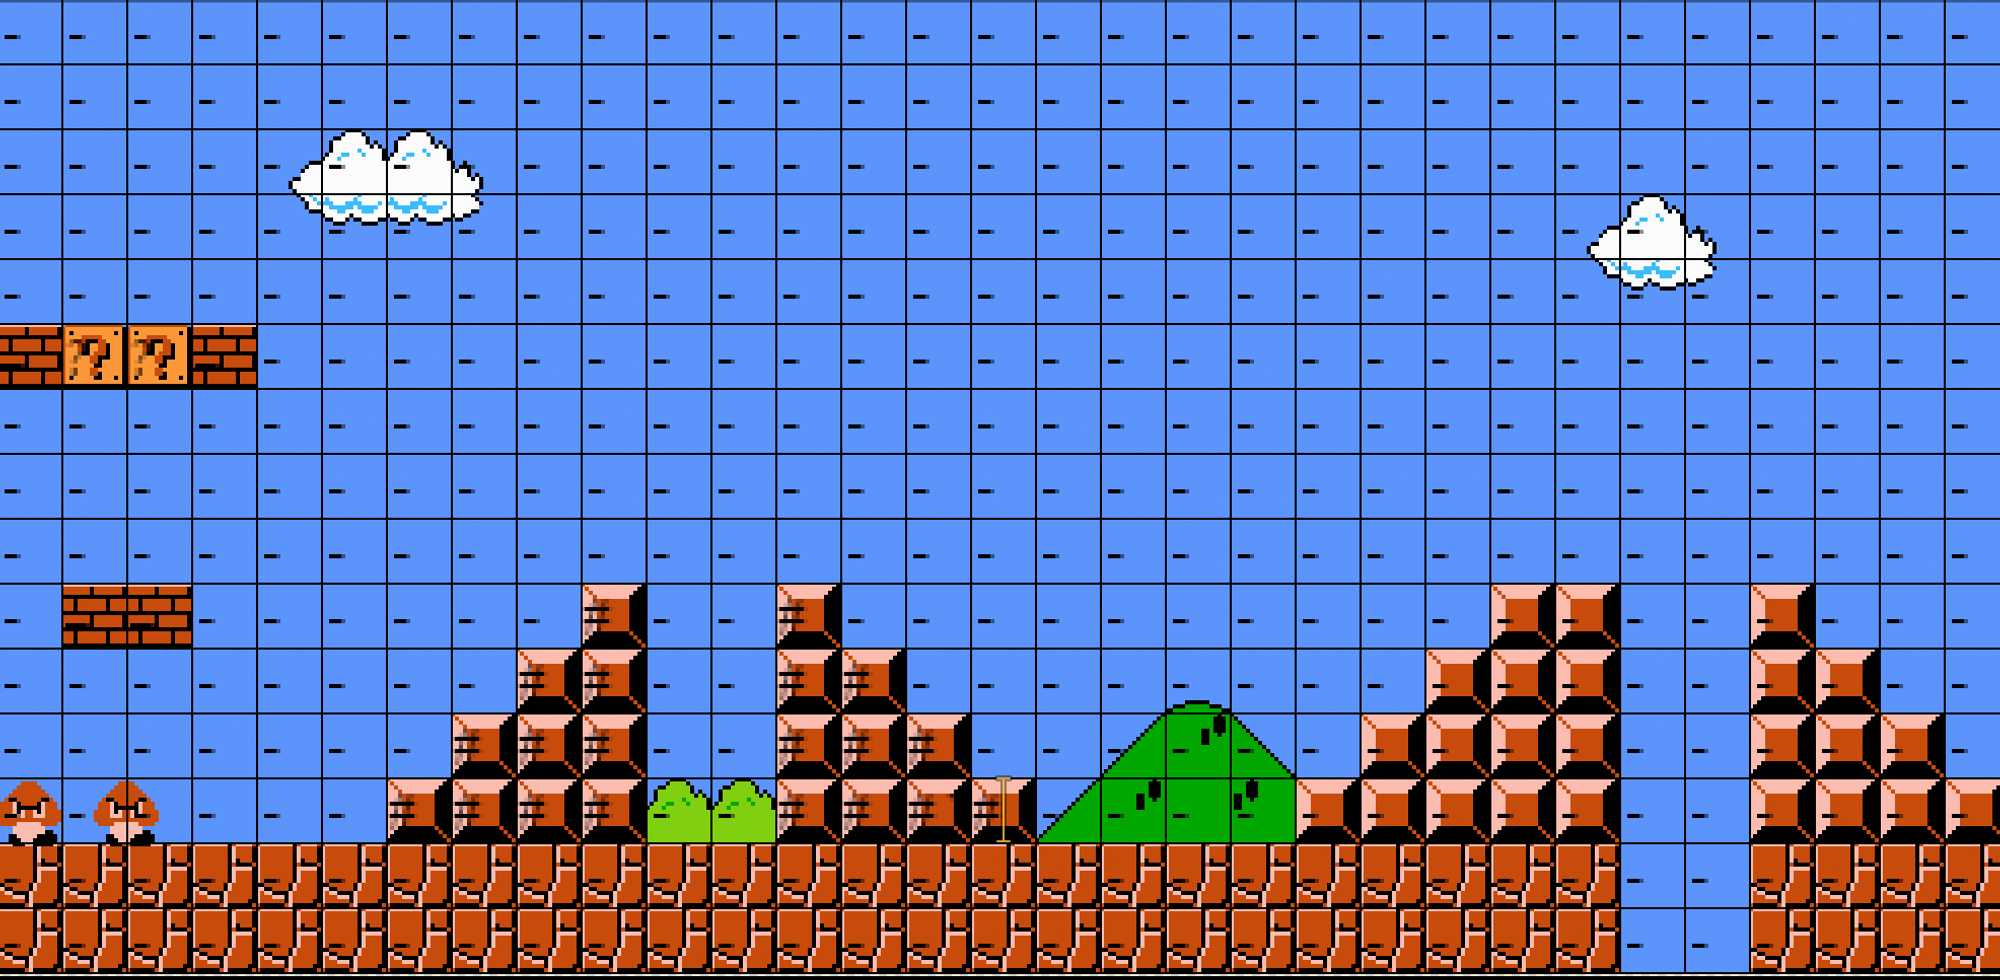

В результате получаем текстовый файл описывающий препятствия


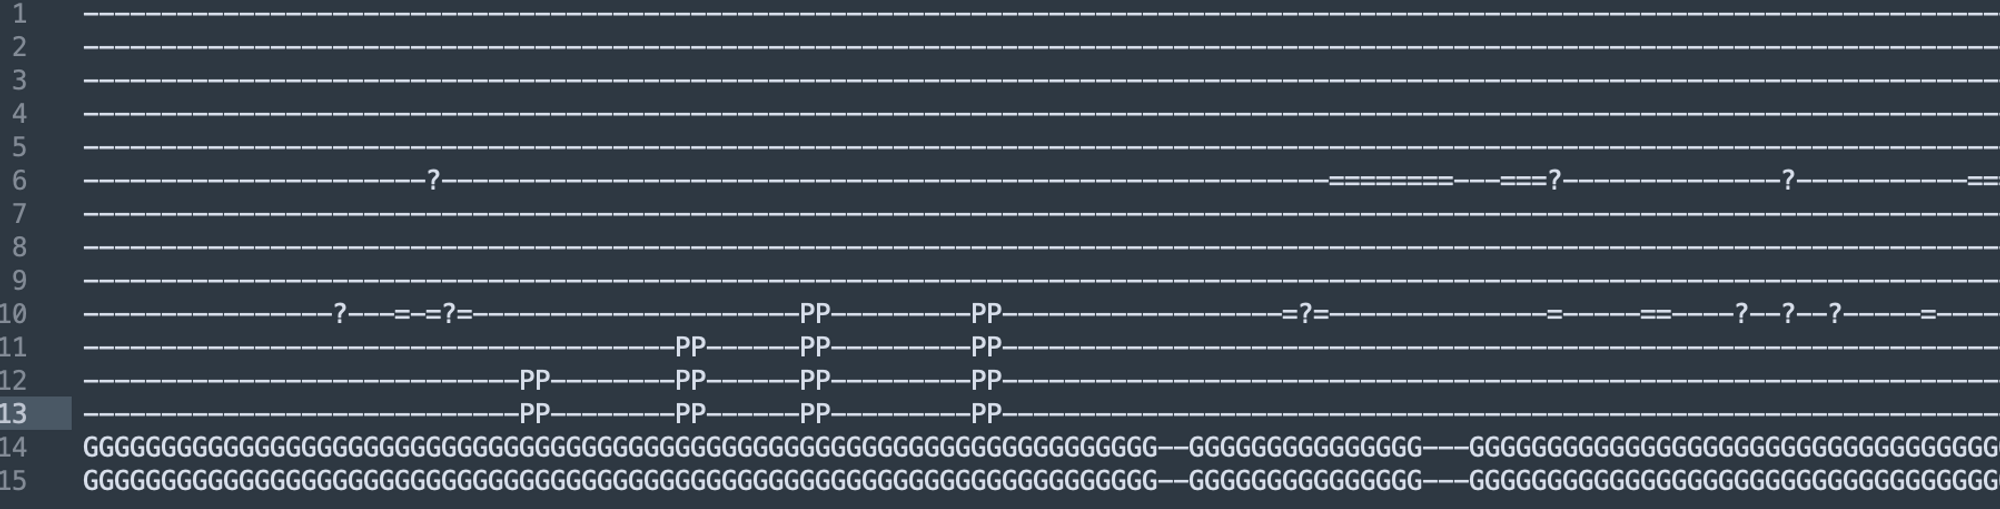

Сохраним его, и приступим к написанию кода

Сначала мы загрузим данные уровня в переменную `Level`

In [ ]:
import numpy as np

fname = '/content/drive/MyDrive/Проекты/ML/Pets/rnn_mario_level_builder/data/MarioL1_.txt'
#np.loadtxt(fname, dtype=’float’, comments=’#’, delimiter=None, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0 encoding='bytes', max_rows=None)

Level = np.loadtxt(fname, dtype='str',comments=None) 
print(Level)

['--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'
 '--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'
 '--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'
 '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------'
 '--------------------------------------------------------------------------------------

Данные не годятся для обучения, так как у нас всего 15 строк и 255 признаков. Если повернем набор, то у нас будет 15 признаков и 255 строк, что уже лучше.

In [ ]:
col=len(Level[0])
row=len(Level)
Level.shape


LevelP=np.zeros((row,col), dtype='S1')

print(LevelP.shape)

for i in range(row):
  
  for j in range(col):
    
    LevelP[i,j]=Level[i][col-j-1]

with np.printoptions(threshold=np.inf, linewidth=1275):
  print(LevelP)

(15, 224)
[[b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-

In [ ]:
coln, rown=LevelP.shape
print(f"row:{rown} col:{coln}")

row:224 col:15


In [ ]:
Приведем данные массива к строковому виду

In [ ]:
raw_text=""

for i in range(rown):
  for j in range(coln):
    raw_text=raw_text+LevelP[j,rown-i-1].decode('UTF-8')
  raw_text=raw_text+'\n'

print(raw_text)

-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
---------?---GG
-------------GG
-------------GG
-------------GG
---------=---GG
-------------GG
-----?---=---GG
---------?---GG
---------=---GG
-------------GG
-------------GG
-------------GG
-----------PPGG
-----------PPGG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
----------PPPGG
----------PPPGG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
---------PPPPGG
---------PPPPGG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
---------PPPPGG
---------PPPPGG
-------------GG
-------------GG
-------------GG
--------

Теперь можно приступать к сборке и обучению модели

In [ ]:
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [ ]:
n_chars = len(raw_text)
n_vocab = len(chars)
print (f"Total Characters: {n_chars}")
print (f"Total Vocab: {n_vocab}")

Total Characters: 3584
Total Vocab: 14


Мы видим, что набор содержит более 3000 символов и что при преобразовании в словаре есть только 14 различных символов для изучения сетью. Гораздо меньше, чем 32 в алфавите.

Теперь нам нужно определить данные обучения для сети. Есть множество вариантов по разбиению текста и подаче его в сеть во время обучения.

На этом этапе мы разделим текст на подпоследовательности с фиксированной длиной в 160 символов.

Каждый обучающий шаблон сети состоит из 160 временных шагов одного символа (X), за которыми следует один символьный вывод (y). При создании этих последовательностей мы перемещаем это окно по всей книге по одному символу за раз, позволяя каждому символу получить шанс из 160 предшествующих ему символов (кроме, конечно, первых 160 символов).

In [ ]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 160
dataX = []
dataY = []

for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)

print (f"Total Patterns: {n_patterns}")

Total Patterns: 3424


Теперь, когда мы подготовили наши тренировочные данные, нам нужно преобразовать их так, чтобы они подходили для использования с Keras.

Сначала мы должны преобразовать список входных последовательностей в форму[образцы, временные шаги, особенности]ожидается сетью LSTM.

Затем нам нужно изменить масштаб целых чисел в диапазоне от 0 до 1, чтобы облегчить изучение шаблонов сетью LSTM, которая по умолчанию использует функцию активации сигмовидной кишки.

Наконец, нам нужно преобразовать выходные шаблоны (отдельные символы, преобразованные в целые числа) в одну горячую кодировку. Это сделано для того, чтобы мы могли настроить сеть так, чтобы она предсказывала вероятность каждого из 14 различных символов в словаре (более простое представление), а не пыталась заставить ее предсказать точно следующий символ. Каждое значение y преобразуется в разреженный вектор длиной 14, полный нулей, за исключением 1 в столбце для буквы (целое число), которую представляет шаблон.

Мы можем реализовать эти шаги, как показано ниже.

In [ ]:
from keras.utils import np_utils

# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint

In [ ]:
y.shape[1]

14

Теперь мы можем определить нашу модель LSTM. Здесь мы определяем один скрытый слой LSTM с 256 единицами памяти. Сеть использует выпадение с вероятностью 20. Выходной уровень - это Плотный уровень, использующий функцию активации softmax для вывода прогнозирования вероятности для каждого из 14 символов в диапазоне от 0 до 1.

Эта проблема на самом деле представляет собой проблему классификации отдельных символов с 14 классами, и поэтому она определяется как оптимизация потерь в журнале (перекрестная энтропия) с использованием алгоритма оптимизации ADAM по скорости.

In [ ]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

Тестового набора данных нет. Мы моделируем весь обучающий набор данных, чтобы узнать вероятность каждого персонажа в последовательности.

Нас не интересует наиболее точная (точность классификации) модель учебного набора данных. Это будет модель, которая идеально предсказывает каждого символа в наборе обучающих данных. Вместо этого мы заинтересованы в обобщении набора данных, который минимизирует выбранную функцию потерь. Мы ищем баланс между обобщением и переобучением, но без запоминания.

Сеть работает медленно (около 300 секунд на эпоху на графическом процессоре Nvidia K520). Из-за медлительности и из-за наших требований по оптимизации мы будем использовать контрольные точки модели для записи всех сетевых весов, чтобы каждый раз регистрировать улучшение потерь в конце эпохи. Мы будем использовать лучший набор весов (наименьшая потеря), чтобы реализовать нашу генеративную модель в следующем разделе.

In [ ]:
# define the checkpoint
filepath="/content/drive/MyDrive/Проекты/ML/Pets/rnn_mario_level_builder/data/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Теперь мы можем приспособить нашу модель к данным. Здесь мы используем скромное количество из 100 эпох и большой размер пакета из 128 шаблонов.

In [ ]:
history=model.fit(X, y, epochs=1000, batch_size=128, callbacks=callbacks_list)

Epoch 1/1000
27/27 [==============================] - ETA: 0s - loss: 0.0184
Epoch 1: loss did not improve from 0.00715
27/27 [==============================] - 2s 25ms/step - loss: 0.0184
Epoch 2/1000
25/27 [==========================>...] - ETA: 0s - loss: 0.0220
Epoch 2: loss did not improve from 0.00715
27/27 [==============================] - 1s 20ms/step - loss: 0.0221
Epoch 3/1000
25/27 [==========================>...] - ETA: 0s - loss: 0.0113
Epoch 3: loss did not improve from 0.00715
27/27 [==============================] - 1s 20ms/step - loss: 0.0116
Epoch 4/1000
25/27 [==========================>...] - ETA: 0s - loss: 0.0127
Epoch 4: loss did not improve from 0.00715
27/27 [==============================] - 1s 20ms/step - loss: 0.0120
Epoch 5/1000
25/27 [==========================>...] - ETA: 0s - loss: 0.0108
Epoch 5: loss did not improve from 0.00715
27/27 [==============================] - 1s 20ms/step - loss: 0.0103
Epoch 6/1000
25/27 [==========================>...] - E

Вы увидите разные результаты из-за стохастической природы модели и из-за того, что трудно подобрать случайное начальное число для моделей LSTM, чтобы получить 100% воспроизводимые результаты. Это не касается этой генеративной модели.

После запуска примера у вас должно быть несколько файлов контрольных точек веса в локальном каталоге.

Вы можете удалить их все, кроме одного с наименьшим значением потери. Например, когда я запускал этот пример, ниже был контрольный пункт с наименьшей потерей, которую я достиг.


`weights-improvement-456-0.0024.hdf5`

In [ ]:
print(history.history.keys())
model.metrics_names

['loss']

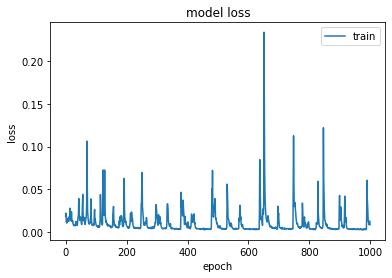

In [ ]:
#| label: fig-loss
#| fig-cap: "График потерь на обучении"

plt.plot(history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#Генерация текста с помощью сети LSTM

Генерация текста с использованием обученной сети LSTM относительно проста.

Во-первых, мы загружаем данные и определяем сеть точно таким же образом, за исключением того, что веса сети загружаются из файла контрольных точек, и сеть не нуждается в обучении.

In [ ]:
# load the network weights
filename = "/content/drive/MyDrive/Проекты/ML/Pets/rnn_mario_level_builder/data/weights-improvement-456-0.0024.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Кроме того, при подготовке сопоставления уникальных символов с целыми числами мы также должны создать обратное отображение, которое мы можем использовать для преобразования целых чисел обратно в символы, чтобы мы могли понять предсказания.

In [ ]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

Наконец, нам нужно делать прогнозы.

Простейший способ использования модели Keras LSTM для прогнозирования - сначала начать с последовательности начальных чисел в качестве входных данных, сгенерировать следующий символ, затем обновить последовательность начальных чисел, чтобы добавить сгенерированный символ в конце, и обрезать первый символ. Этот процесс повторяется до тех пор, пока мы хотим предсказать новые символы (например, последовательность длиной 1000 символов).

Мы можем выбрать случайный шаблон ввода в качестве нашей начальной последовательности, а затем распечатать сгенерированные символы по мере их генерации.

In [ ]:
import sys
# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]

print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

# generate characters
for i in range(500):
	x = np.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = np.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]

print("\nDone.")

Seed:
" -------#GG
-----------##GG
----------###GG
---------####GG
---------####GG
---------------
---------------
---------####GG
----------###GG
-----------##GG
----- "
-------#GG
-------------GG
-------------GG
-------------GG
-------------GG
-----------PPGG
-----------PPGG
-------------GG
-------------GG
-------------GG
---------=---GG
---------=---GG
---------?---GG
---------=---GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-------------GG
-----------PPGG
-----------PPGG
------------#GG
-----------##GG
----------###GG
---------####GG
--------#####GG
-------######GG
------#######GG
-----########GG
-----####
Done.
